In [74]:
#%matplotlib widget
from time import time
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from functools import lru_cache
import numpy as np
from scipy import ndimage, stats
from itertools import islice

In [3]:
# Optical Flow Based
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

def mutating_base_calcs(df, n):
    df['dx'] = df.x2 - df.x1 + 0.00001
    df['dy'] = (df.y2 - df.y1)/n
    df['Vf_slope'] = df.dy/df.dx
    df['|Vf|'] = np.sqrt(df.dx**2 + df.dy**2)

    df['right_direction'] = (df.y2>df.y1) & (abs(df.Vf_slope) > 3) # down and steep
    df['good'] = df['right_direction']

def analyze_lk_optical_flow_dfs(dfs):
    xs = []
    def analyze_df(df):
        nonlocal xs
        # absurd
        #df['good'] = df['good'] & (df['|Vf|'] > 2.5)
        df['good'] = df['good'] & (df['|Vf|'] < (35/.45)) #25 is data set max, .45 coverts from Vf to velocity
        
        if sum(df['good']==True) == 0:
            xs += [np.nan, np.nan]
        else:
            with np.errstate(divide='ignore',invalid='ignore'):
                df.loc[df['good'],'z'] = stats.zscore(df.loc[df['good'],'|Vf|'])
            df.loc[df['good']==False,'z'] = 100.0
            df['good'] = df['good'] & (df['z'] < 1.7)

            if len(df) != 0:
                # filter out noisy "small" flow vectors
                Vf_max_good = df[df['good']==True]['|Vf|'].max()
                df['good'] = df['good'] & (df['|Vf|'] > Vf_max_good * 0.25)
            xs.append(df.loc[df['good'],'|Vf|'].mean())
            xs.append(df.loc[df['good'],'|Vf|'].std())
        xs.append(df['dy'].mean())
    overall = 0
    for n, df in enumerate(dfs):
        global N
        N = n + 1
        mutating_base_calcs(df,N)
        analyze_df(df)
        
        overall += df.loc[df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    stacked_df = pd.concat(dfs, ignore_index=True)
    analyze_df(stacked_df)
    overall += stacked_df.loc[stacked_df['good'],'|Vf|'].mean()/(len(dfs)+1)
    
    xs.append(overall)

    # 0 1 2 #n=1
    # 3 4 5 #n=2
    # 6 7 8 #n=3
    # 9 10 11 #stacked
    # 12 #overall
    return xs

def via_lk_optical_flow_multi(frame, count=3):
    frame['optical_flow'] = []
    dfs = []
    for i in range(1, count+1):
        dfs.append(optical_flow(frame['_'], frame[str(i)], frame))
    return analyze_lk_optical_flow_dfs(dfs)

def debug_optical(df,img):
    img = image_next.copy()
    # we lose old arrow debugging with the df approach, sorry
    #         if right_direction:
    #             color=255
    #             df.loc[i,'good'] = True
    #         else:
    #             color=130
    #             df.loc[i,'good'] = False

    #         if debugging:
    #             img = cv2.arrowedLine(img,(int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
    #             img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    if len(df) == 0:
        print("no useful points")
    else:
        display(df.sort_values(by='|Vf|'))       
        bins = list(range(0,101,10))
        plt.rcParams['figure.figsize'] = [20, 5]
        df['|Vf|'].hist(bins=bins)
        df[df['good']==True]['|Vf|'].hist(bins=bins)
        plt.show()

    plt.rcParams['figure.figsize'] = [20, 12]
    plt.imshow(img)
    plt.show()

# params for ShiTomasi corner detection
feature_params = dict(
    maxCorners = 100,
    qualityLevel = 0.007,
    minDistance = 20,
    blockSize = 9,
    #useHarrisDetector = True,
    )

# Parameters for lucas kanade optical flow
lk_params = dict(
    winSize  = (15,15),
    maxLevel = 1,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )

def optical_flow(image, image_next, frame, debugging=False):
    p0 = cv2.goodFeaturesToTrack(image, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(image, image_next, p0, None, **lk_params)
    
    points = []
    for new, old in zip(p1[st==1],p0[st==1]):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        points.append((x1,x2,y1,y2))
    
    df = pd.DataFrame(data=points, columns=('x1','x2','y1','y2'))
    if debugging:
        debug_optical(df,img)

    frame['optical_flow'].append(df)
    return df


In [5]:
# Process frames
def frames(file='../data/train.mp4'):
    vidcap = cv2.VideoCapture(file)
    while True:
        success, image = vidcap.read()
        if success:
            yield {'orig': image, '_': image, 'xs':[]}
        else:
            return

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def lookahead(frames, count=3):
    # add "lookahead" in keys '1', '2', ...
    # repeats at the end to keep length len
    fs = list()
    
    def _updated_f():
        f = fs.pop(0)
        f.update({str(n+1):f['_'] for n, f in enumerate(fs)})
        return f 
        
    for f in frames:
        fs.append(f)
        if len(fs) > count:
            yield _updated_f()

    for _ in range(count):
        fs.append(f)
        yield _updated_f()
        
def print_frame_keys(frames):
    for f in frames:
        print(repr(list(f.keys())))
        yield f

def view_frames(frames):
    for f in frames:
        for k in f.keys():
            try:
                cv2.imshow(k,f[k])
            except:
                pass
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f
    cv2.destroyAllWindows()

def persist_raw_optical_flow(frames):
    import os
    path = f'./data/{int(time())}'
    os.makedirs(path)
    for i, f in enumerate(frames):
        for j, df in enumerate(f['optical_flow']):
            df: pd.DataFrame
            df.to_pickle(os.path.join(path,f'{i}_{j}.pkl'))
        yield f

class FeatureExtractor():
    def __init__(self, frames_generator_maker):
        self._frames = frames_generator_maker
        self._steps = []
    def add_step(self, step):
        """step(frames_iterator) yields-> [frame,frame,...]; you can filter or gather frames"""
        if callable(step):
            self._steps.append(step)
    def add_processor(self, processor):
        """processor(img) returns-> img; frame['_'] is mutated"""
        def _step(frames):
            for f in frames:
                f['_'] = processor(f['_'])
                yield f
        self.add_step(_step)
    def add_analyzer(self, analyzer):
        """analyzer(frame) returns-> [x1,x2,...]; frame['_'] is forwarded untouched, features are collected"""
        def _step(frames):
            for f in frames:
                f['xs'] += analyzer(f)
                yield f
        self.add_step(_step)

    def __iter__(self):
        pipeline = self._frames()
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline
    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self._start)/60:2.1f} minutes")
    def extract_features(self):
        self._start = time()
        self._last = self._start
        X = []
        i=0
        for i, f in enumerate(self):
            X.append(f['xs'])
            self._pprogress(i)
        self._pprogress(i,True)
        return X
import shutil

In [6]:
fe = FeatureExtractor(frames)

#fe.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#fe.add_step(lambda g: islice(g, 400, 420, 1)) # limit frames (start, stop, step)

fe.add_processor(lambda img: crop(img, bottom=100, top=220))
fe.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
fe.add_processor(fix_perspective)
fe.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

fe.add_step(lambda frames: lookahead(frames, count=3))

fe.add_analyzer(via_lk_optical_flow_multi)

#fe.add_step(persist_raw_optical_flow)
#fe.add_step(print_frame_keys)
#fe.add_step(view_frames)

xs = fe.extract_features()

252 processed in 0.5 minutes
497 processed in 1.0 minutes
738 processed in 1.5 minutes
988 processed in 2.0 minutes
1243 processed in 2.5 minutes
1490 processed in 3.0 minutes
1731 processed in 3.5 minutes
1981 processed in 4.0 minutes
2205 processed in 4.5 minutes
2440 processed in 5.0 minutes
2684 processed in 5.5 minutes
2937 processed in 6.0 minutes
3188 processed in 6.5 minutes
3427 processed in 7.0 minutes
3673 processed in 7.5 minutes
3903 processed in 8.0 minutes
4148 processed in 8.5 minutes
4392 processed in 9.0 minutes
4637 processed in 9.5 minutes
4876 processed in 10.0 minutes
5108 processed in 10.5 minutes
5355 processed in 11.0 minutes
5599 processed in 11.5 minutes
5822 processed in 12.0 minutes
6051 processed in 12.5 minutes
6298 processed in 13.0 minutes
6547 processed in 13.5 minutes
6802 processed in 14.0 minutes
7050 processed in 14.5 minutes
7293 processed in 15.0 minutes
7541 processed in 15.5 minutes
7766 processed in 16.0 minutes
7995 processed in 16.5 minutes


In [75]:
def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)

In [76]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,20301.000000,20199.000000,20400.000000,20171.000000,20038.000000,20399.000000,19960.000000,19799.000000,20399.000000,20300.000000,20277.000000,20400.000000,19907.000000,20400.000000,20400.000000,20400.000000
mean,22.052734,5.525136,4.799234,21.724671,5.542001,2.844092,21.518410,5.687407,2.333646,21.417903,5.424170,3.357223,21.750685,2.429951,3.254773,3.384131
std,16.133754,4.117217,9.669150,15.673859,4.248105,7.581492,15.271258,4.529610,6.865346,15.371821,3.901604,7.012366,15.284451,1.381638,2.112268,1.639592
min,0.004153,0.002088,-116.187047,0.001527,0.000472,-126.458439,0.002043,0.000354,-99.169061,0.002558,0.001149,-114.883626,0.032415,0.348827,0.441444,0.421173
25%,8.168556,2.425897,-0.238537,8.194919,2.224346,-0.818561,8.350239,2.147118,-0.985925,8.177106,2.313584,-0.352002,8.562533,1.495517,1.848284,2.115873
50%,17.904147,4.502413,3.863911,17.847354,4.385355,2.245137,17.948092,4.433294,1.793814,17.581195,4.558648,2.688383,18.125114,2.148932,2.849210,3.103574
75%,35.406030,7.734051,9.793322,35.071106,8.178047,6.362307,34.640009,8.480785,5.344351,34.780746,8.106215,6.777629,35.137876,3.003370,4.121873,4.284229
max,73.891515,38.534682,83.617086,77.726476,34.490408,52.578316,77.525239,39.584484,48.778914,73.523423,38.534682,49.815615,66.597995,14.013617,19.977022,23.558937


In [98]:
#X.fillna(value=0, inplace=True)
X.fillna(method='pad', inplace=True)
#X=X[[0,2,4,3,'024']] # 1,2,3 frame Vf and 2-frame std, and linear average of the three Vf
    # 0 1 2 #n=1
    # 3 4 5 #n=2
    # 6 7 8 #n=3
    # 9 10 11 #stacked
    # 12 #overall
#X=X[[0,1,2,  3,4,5,  6,7,8  ,9]]
X=X[[4,12]]
X.describe()

,4,12
count,20400.000000,20400.000000
mean,5.529350,21.619300
std,4.297414,15.307600
min,0.000472,0.032415
25%,2.181652,8.436889
50%,4.361080,17.970307
75%,8.169529,34.925562
max,34.490408,66.597995


In [99]:
Xy = X.copy()
Xy['y'] = y

chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,4,12,y
0,16.495188,47.106766,28.105569
1,12.624079,47.106766,28.105569
2,18.046436,54.690009,28.106527
3,7.928414,54.690009,28.130404
4,8.151717,37.585372,28.109243
...,...,...,...
9787,4.897533,13.006839,7.308992
9788,4.741705,13.474143,7.361846
9789,2.647082,12.219969,7.382163
9790,2.902791,11.648080,7.385023


In [100]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

m_ensemble = StackingRegressor([
   ('svr', SVR(C=4)),
   ('rf', RandomForestRegressor(n_estimators=60)),
   #('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
   ])

pipe = Pipeline([
    ('scale', StandardScaler()),
    #('poly', PolynomialFeatures(interaction_only=False, include_bias=False)),
    #'reduce_dims', PCA(n_components=4)),
    ('svr', SVR(C=2)),
    #('rf', RandomForestRegressor()),
    #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
    #('br', BayesianRidge()),
    #('stack', m_ensemble),
    #('lin', LinearRegression()),
    ])

# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    #'stack__svr__C':[0.0001, 0.001,.01, .1, .3, .9, 2, 4, 10, 15, 20, 50, 100, 200],
    #'stack__rf__n_estimators': [3, 5, 8, 10, 20, 50, 100, 150],
    #'stack__rf__max_depth': None,

    'svr__C':np.logspace(-5,5, num=23,base=2.7)
    #'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=8, cv=7)

m_real = grid


In [102]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Fitting 7 folds for each of 23 candidates, totalling 161 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   27.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   43.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   51.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done 161 out of 161 | elapsed:  2.8min finished


Pipeline(steps=[('scale', StandardScaler()), ('svr', SVR())])


In [103]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [104]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0009]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
#kf = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [105]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [106]:
# never below 0
Xy2.loc[Xy2['pred_kf'] < 0.0,'pred_kf'] = 0.0

In [95]:
#target_mean = Xy2.loc[Xy2_train_ix,'y'].mean()
#target_mean = Xy2['y'].mean() # for full comparison, overly optimistic though

NoMLCol = 9
velocity_per_vf = .577

Xy2['NoML_kf'] = kf.smooth(Xy2[NoMLCol].values)[0] * velocity_per_vf
Xy2['NoML_scaled'] = Xy2[NoMLCol] * velocity_per_vf


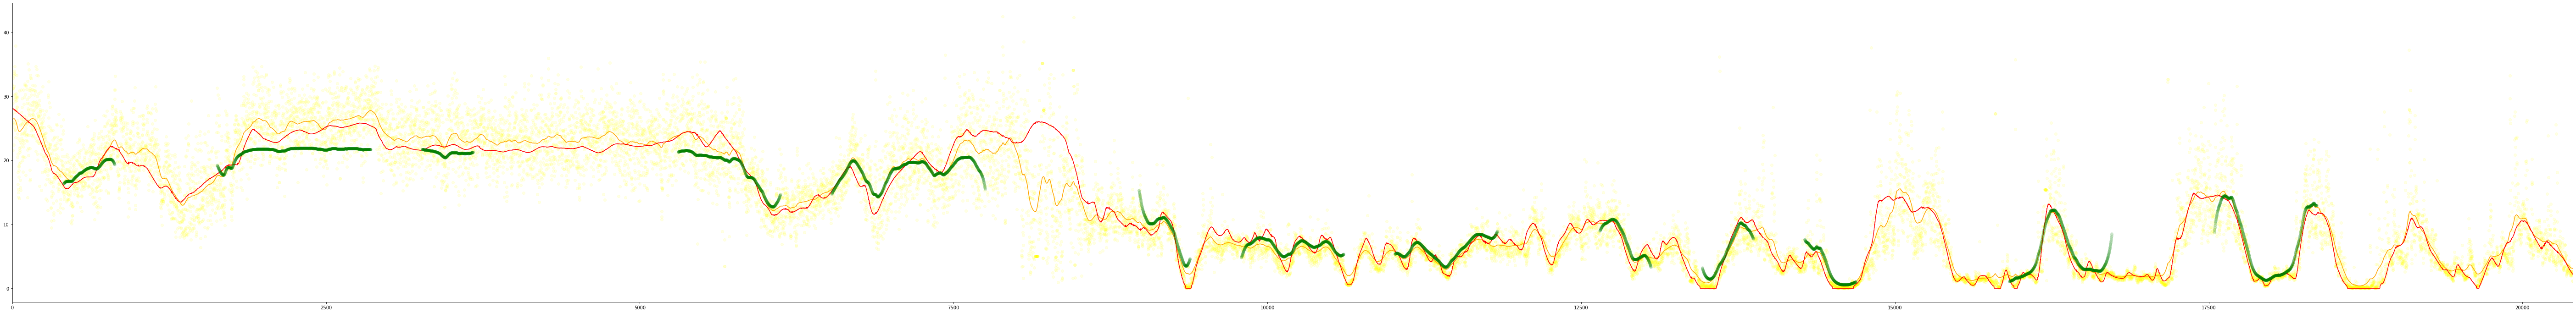

In [96]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    try:
        if ix_mask is None:
            df = Xy2.loc[:,column]
        else:
            df = Xy2.loc[ix_mask, column]
        plt.plot(df.index, df.values, **kwargs)
    except KeyError:
        print(f"Skipping {column}")
    
#plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)
#plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, 'NoML_scaled', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_Xy2(None, 'NoML_kf', marker='', linewidth=1.5, color='orange')
#plot_Xy2(None, 4, marker='', linewidth=0.5, color='blue')
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)

In [97]:
def print_summary_line(ix_mask, column='dum'):
    if ix_mask is not None:
        Xy = Xy2[ix_mask]
    else:
        Xy = Xy2
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end='\t')

print(f"dummy\ttest\ttrain\ttest_kf\tNoML")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')
print_summary_line(None,'NoML_kf') # 10.3 was best, gaussian made it 7.2

dummy	test	train	test_kf	NoML
70.6	7.3	12.3	3.5	3.6	

dummy	test	train	test_kf	NoML
69.6	16.6	5.6	7.7	13.5	

^^^^got this,,,,,why>???????? trying to lower absurity ceiling again 260->160
maybe column multiplication should be done _after_ forward fillign/padding Xdf

In [24]:
Xy2.describe()

,3,4,5,9,12,y,dum,pred,pred_kf,NoML_kf,NoML_scaled
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,2.040000e+04,20400.000000,8976.000000,20400.000000,20400.000000
mean,21.659652,5.529350,2.844011,21.412267,21.619300,12.183182,1.089722e+01,11.902945,13.141992,12.473072,12.474336
std,15.682116,4.297414,7.581315,15.390543,15.307600,8.206763,3.552801e-15,7.351695,6.979028,8.129110,8.832485
min,0.001527,0.000472,-126.458439,0.002558,0.032415,0.000000,1.089722e+01,0.187327,0.439770,0.327198,0.018703
25%,8.134658,2.181652,-0.818544,8.172423,8.436889,5.011801,1.089722e+01,5.457333,6.204412,5.355035,4.868085
50%,17.821339,4.361080,2.245015,17.549174,17.970307,10.600500,1.089722e+01,10.800401,13.894864,10.797086,10.368867
75%,34.994750,8.169529,6.361703,34.773626,34.925562,21.324059,1.089722e+01,19.951511,20.054289,21.041719,20.152049
max,77.726476,34.490408,52.578316,73.523423,66.597995,28.130404,1.089722e+01,22.436041,21.481470,27.847267,38.427043


In [25]:
df = Xy2.copy()
df = df.groupby(np.arange(len(df.index)) // 100).mean()
df['loss']=abs(df['y']-df['NoML_kf'])
#plt.plot(df.index, df.values)


In [26]:
df.sort_values(by='loss', ascending=False).head(10).index.values

array([ 81,  83,  82,  80,  84,  11,  77, 149,  10,  56])

# inference

In [ ]:
# be sure pipeline is set up the same in both places
columns_used_to_train = X.columns

In [ ]:
feo = FeatureExtractor(lambda: frames(file='../data/train.mp4'))

#feo.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#feo.add_step(lambda g: islice(g, 400, 420, 1)) # limit frames (start, stop, step)

feo.add_processor(lambda img: crop(img, bottom=100, top=220))
feo.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
feo.add_processor(fix_perspective)
feo.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

feo.add_step(lambda frames: lookahead(frames, count=3))

#feo.add_analyzer(via_lk_optical_flow)
feo.add_analyzer(via_lk_optical_flow_multi)
feo.add_analyzer(via_variance_of_laplacian)
feo.add_analyzer(via_diff)

#feo.add_step(print_frame_keys)
#feo.add_step(view_frames)

xso = fe.extract_features()

In [ ]:
columns_used_to_train